## Predictive Modeling - Neural network

In [1]:
import re
import numpy as np
import pandas as pd
import json
import sys
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from keras import layers
from keras.models import Sequential, load_model
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt
%matplotlib inline

import nltk
nltk.download("stopwords")
nltk.download('punkt')

Using TensorFlow backend.


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\cbliou\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\cbliou\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
library = "C:\\Users\\liblabs-user\\Desktop\\song-authorship\\data"
laptop = "not yet"
desktop = "C:\\Users\\Sam\\Desktop\\song authorship\\data"
statlab = "C:\\Users\\cbliou\\Desktop\\song-authorship\\data"

Since lyrics do not have sentences, we will delimit the sentences using the new line character.

In [3]:
def clean_text(text, names, unicode_replace):
    remove = ["_", "*", "--", ",", "!", "?", " < ", " > ", ":"]
    repl = {"\<u\+0092\>": "'",
            "\<u\+0097\>": "-",
            "\<u\+00..\>": "",
            " '{0,}": " ",
            "\.{0,} ": " ",
            " \.{0,}": " ",
            ' "{0,}': " ",
            '"{0,} ': " ",
            }
    #text_repl = {
    #    "([A-z])\\1{2,}": "\\1\\1", # ayyyy -> ayy
    #    #"([A-z])'[A-z]+": '\\1', # remove contractions
    #    "[^A-z]": '' # remove punctuations
    #}
    text = text.lower()
    for x in remove:
        text = text.replace(x, "")
    for x in repl:
        text = re.sub(x, repl[x], text, flags = re.I | re.S)
    for x in unicode_replace:
        text = re.sub(x, "", text, flags = re.I | re.S)
    #for x in text_repl:
    #    text = re.sub(x, text_repl[x], text, flags = re.I | re.S)
    return [x.strip() for x in re.split("\n", text) if x.strip() != ""]

def data_generator(robot, nonrobot, s_min, s_max, a_min, a_max,
                   lookback, batch_size=128):

    if s_max is None:
        s_max = len(robot)
    if a_max is None:
        a_max = len(nonrobot)

    si = s_min
    ai = a_min

    while 1:

        follow = np.random.randint(0, 2, batch_size)
        sind = []
        aind = []

        for x in follow:
            # robotic is 0
            if x == 0:
                if si >= s_max:
                    si = s_min
                sind.append(si)
                aind.append(-1)
                si += 1
            else:
                if ai >= a_max:
                    ai = a_min
                aind.append(ai)
                sind.append(-1)
                ai += 1

        samples = []

        # now pad sentences and yield.
        for x in range(len(sind)):
            # sampled non-robotic here
            if sind[x] == -1:
                samples.append(nonrobot[aind[x]])
            else:
                samples.append(robot[sind[x]])

        yield np.array(samples), follow
        
def combine_phrases(n, song):
    """
    n: Number of phrases to combine together
    song: list of phrases to combine
    
    returns: list of combined sentences.
    """
    
    if len(song) <= n:
        return [" ".join(song)]
    else:
        add = []
        itor = list(range(0, len(song) - n, n))
        for i in itor:
            add.append(" ".join(song[i: i + n]))
        
        add.append(" ".join(song[itor[-1] + n:]))

        return add
    
def prepare_data(sentence, stopwords):
    sentence = word_tokenize(sentence)
    #sentence = [i for i in sentence if i not in stopwords]
    return sentence

In [4]:
split = 0.8
number_of_words = 5000
num_combine = 3
np.random.seed(0)

In [11]:
df = pd.read_csv(open(statlab + "\\Weekly_data_top_week.csv", "r", encoding = "utf-8", errors = "backslashreplace"))
names = "\s"
unicode_replace  = json.load(open(statlab + "\\unicoderemove.json", "r"))
stop = set(stopwords.words('english'))

robotic = [clean_text(x, names, unicode_replace) 
           for x in df[df.Songwriter == True].Lyrics]
nonrobotic = [clean_text(x, names, unicode_replace) 
              for x in df[df.Songwriter == False].Lyrics]

robotic = [combine_phrases(num_combine, i) for i in robotic]
nonrobotic = [combine_phrases(num_combine, i) for i in nonrobotic]

# test train split
rt = np.random.choice(len(robotic),
                      round(len(robotic) * split),
                      replace=False)
rtrain = [prepare_data(y, stop) for x in rt for y in robotic[x]]
rtest = [prepare_data(y, stop) for x in set(range(len(robotic))).difference(rt) for y in robotic[x]]

nt = np.random.choice(len(nonrobotic),
                      round(len(nonrobotic) * split),
                      replace=False)
ntrain = [prepare_data(y, stop) for x in nt for y in nonrobotic[x]]
ntest = [prepare_data(y, stop) for x in set(range(len(nonrobotic))).difference(nt) for y in nonrobotic[x]]

# vectorize sentences
tokenizer = Tokenizer(num_words=number_of_words,
                      filters="'!\"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'",
                      lower=True, split=' ')
tokenizer.fit_on_texts(rtrain)
tokenizer.fit_on_texts(ntrain)
tokenizer.fit_on_texts(rtest)
tokenizer.fit_on_texts(ntest)

rtrain = pad_sequences(tokenizer.texts_to_sequences(rtrain), 30)
#print()
#print(rtrain[0:10])
rtest = pad_sequences(tokenizer.texts_to_sequences(rtest), 30)
ntrain = pad_sequences(tokenizer.texts_to_sequences(ntrain), 30)
ntest = pad_sequences(tokenizer.texts_to_sequences(ntest), 30)

In [12]:
max(tokenizer.word_index.values())

30132

In [13]:
lookback = 30
batch_size = 8

#stoker = pad_sequences(np.array(json.load(open(sys.argv[1].strip()))), 60)
#austen = pad_sequences(np.array(json.load(open(sys.argv[2].strip()))), 60)

#stoker_train = stoker[:round(len(stoker) * 0.9)]
#stoker_val = stoker[round(len(stoker) * 0.9):]

#austen_train = austen[:round(len(austen) * 0.9)]
#austen_val = austen[round(len(austen) * 0.9):]

train_gen = data_generator(robot=rtrain,
                           nonrobot=ntrain,
                           s_min=0,
                           s_max=len(rtrain),
                           a_min=0,
                           a_max=len(ntrain),
                           lookback=lookback,
                           batch_size=batch_size)

val_gen = data_generator(robot=rtest,
                         nonrobot=ntest,
                         s_min=0,
                         s_max=len(rtest),
                         a_min=0,
                         a_max=len(ntest),
                         lookback=lookback,
                         batch_size=batch_size)

model = Sequential()
model.add(layers.Embedding(number_of_words, 64))
model.add(layers.Bidirectional(
            layers.LSTM(16,
            activation="relu",
            dropout=0.2,
            recurrent_dropout=0.2,
            return_sequences=True)))
model.add(layers.Bidirectional(
            layers.LSTM(8,
            activation="relu",
            recurrent_dropout=0.2,
            return_sequences=True)))
model.add(layers.GlobalMaxPool1D())

model.add(layers.Dense(1, activation="sigmoid"))

model.compile(optimizer=RMSprop(),
              loss="binary_crossentropy",
                metrics=["acc"])

filepath = "weights-improvement-{epoch:02d}-{val_acc:.4f}.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc',
                             verbose=1, save_best_only=True,
                             mode='max')
callbacks_list = [checkpoint]

history = model.fit_generator(train_gen,
                              steps_per_epoch=200,
                              epochs=20,
                              callbacks=callbacks_list,
                              validation_data=val_gen,
                              validation_steps=200)

#with open("Embedding.dat", "w") as f:
#    porv = load_model("RoboticorNot.h5")
#    json.dump(list([list(x) for x in
#                    porv.layers[0].get_weights()[0].astype(float)]), f)

Epoch 1/20
200/200 [==============================] - 10s 51ms/step - loss: 0.6871 - acc: 0.5506 - val_loss: 0.6942 - val_acc: 0.4894

Epoch 00001: val_acc improved from -inf to 0.48938, saving model to weights-improvement-01-0.4894.h5
Epoch 2/20
200/200 [==============================] - 7s 36ms/step - loss: 0.7069 - acc: 0.5363 - val_loss: 0.6890 - val_acc: 0.5375

Epoch 00002: val_acc improved from 0.48938 to 0.53750, saving model to weights-improvement-02-0.5375.h5
Epoch 3/20
200/200 [==============================] - 7s 36ms/step - loss: 0.6846 - acc: 0.5994 - val_loss: 0.9974 - val_acc: 0.5619

Epoch 00003: val_acc improved from 0.53750 to 0.56188, saving model to weights-improvement-03-0.5619.h5
Epoch 4/20
200/200 [==============================] - 7s 36ms/step - loss: 0.7006 - acc: 0.6069 - val_loss: 0.7057 - val_acc: 0.5312

Epoch 00004: val_acc did not improve from 0.56188
Epoch 5/20
200/200 [==============================] - 7s 36ms/step - loss: 0.7788 - acc: 0.6262 - val_lo

## Validation

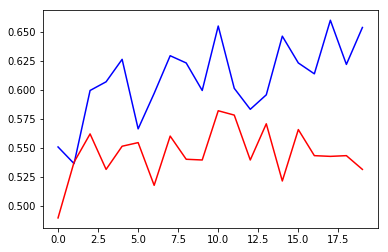

In [14]:
h = history.history
plt.plot(h["acc"], c = "b")
plt.plot(h["val_acc"], c = "r")

In [15]:
# nn = load_model("C:\\Users\\cbliou\\Desktop\\song-authorship\\notebooks\8-15  -  first drafts\\weights-improvement-11-0.5819.h5")

In [16]:
rprd = nn.predict(rtest)
nprd = nn.predict(ntest)

In [22]:
from sklearn.metrics import confusion_matrix

ModuleNotFoundError: No module named 'sklearn'

In [ ]:
c_mat = confusion_matrix(
    [1 for _ in rprd] + [0 for _ in nprd],
    np.append(np.round(rprd), np.round(nprd))
)

In [ ]:
1067 / sum(c_mat[:,1])